# Azerbaijan Grand Prix 2024

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import fastf1.plotting

# Load FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,
                          color_scheme='fastf1')

In [314]:
# fastf1.Cache.enable_cache('path/to/cache')

In [315]:
session = fastf1.get_session(2024, 17, 'R')
session.load(telemetry=False, weather=False)

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
req            INFO 	Data has been written to cache!
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2024/17/results.json failed; using cached response
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/FinalProject/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/FinalProject/lib/python3.12/site-packages/urllib3/connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^

In [316]:
def position_changes(session):

    title = session.event.loc['EventName']

    fig, ax = plt.subplots(figsize=(8.0, 4.9))

    for drv in session.drivers:
        drv_laps = session.laps.pick_drivers([drv])

        try:
            abb = drv_laps['Driver'].iloc[0]
            style = fastf1.plotting.get_driver_style(identifier=abb,
                                                    style=['color', 'linestyle'],
                                                    session=session)

            ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
                    label=abb, **style)
            
        except IndexError:
            print('Driver not found. Probably DNS')
        
    ax.set_ylim([20.5, 0.5])
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_xlabel('Lap')
    ax.set_ylabel('Position')
    ax.set_title(f'Position changes | {title}')

    ax.legend(bbox_to_anchor=(1.0, 1.02))
    plt.tight_layout()

    

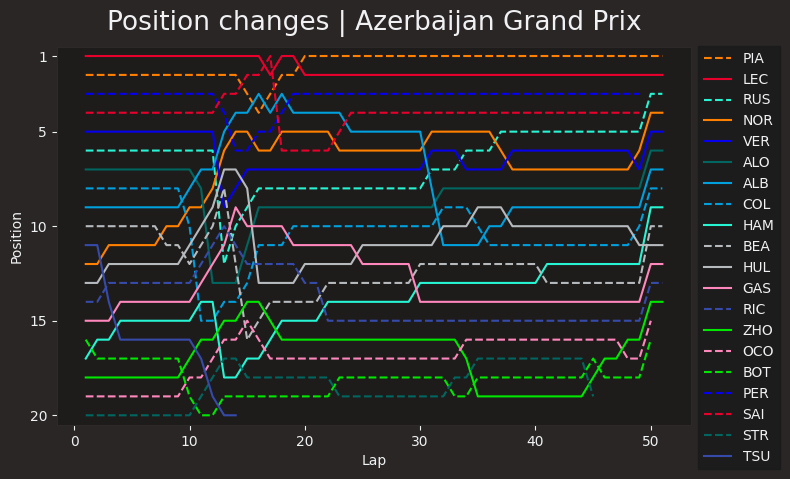

In [317]:
position_changes(session)

In [318]:
import plotly.graph_objects as go
import fastf1.plotting

def position_changes_plotly(session):
    # Configurar esquema de colores oscuro de FastF1
    fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False, color_scheme='fastf1')

    title = session.event.loc['EventName']

    # Mapeo de estilos de línea
    linestyle_map = {
        'solid': 'solid',
        'dashed': 'dash',
        'dotted': 'dot',
        'dashdot': 'dashdot',
        'longdash': 'longdashdot'
    }

    # Crear figura de Plotly
    fig = go.Figure()

    for drv in session.drivers:
        drv_laps = session.laps.pick_drivers([drv])

        try:
            abb = drv_laps['Driver'].iloc[0]
            style = fastf1.plotting.get_driver_style(identifier=abb,
                                                     style=['color', 'linestyle'],
                                                     session=session)

            # Convertir el estilo de línea al formato de Plotly
            plotly_dash_style = linestyle_map.get(style['linestyle'], 'solid')

            fig.add_trace(go.Scatter(
                x=drv_laps['LapNumber'],
                y=drv_laps['Position'],
                mode='lines',
                name=abb,
                line=dict(color=style['color'], dash=plotly_dash_style)
            ))

        except IndexError:
            print('Driver not found. Probably DNS')

    # Aplicar tema oscuro a la figura
    fig.update_layout(
        title=f'Position changes | {title}',
        xaxis_title='Lap',
        yaxis_title='Position',
        yaxis=dict(
            autorange='reversed',
            tickvals=[1, 5, 10, 15, 20],
            gridcolor='rgba(255, 255, 255, 0.1)',  # Color de la cuadrícula
        ),
        xaxis=dict(
            gridcolor='rgba(255, 255, 255, 0.1)'  # Color de la cuadrícula
        ),
        legend=dict(
            x=1.02, y=1, borderwidth=1,
            bgcolor='rgba(0, 0, 0, 0.5)',  # Fondo transparente de la leyenda
            font=dict(color='white')  # Texto de la leyenda en blanco
        ),
        margin=dict(t=50, r=150, b=50, l=50),
        width=800,
        height=500,
        plot_bgcolor='black',  # Fondo del gráfico
        paper_bgcolor='black',  # Fondo general
        font=dict(color='white')  # Texto general en blanco
    )

    fig.show()


In [319]:
position_changes_plotly(session)

---

## Results

Aquí vamos a crear el dataframe con los resultados. Luego ya lo formatearemos en Streamlit o directamente en Pandas. Tendremos que hacer pruebas.

In [320]:
df_results = session.results.copy()

In [321]:
df_results.sample()

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points
63,63,G RUSSELL,RUS,russell,Mercedes,27F4D2,mercedes,George,Russell,George Russell,...,GBR,3.0,3,5.0,NaT,NaT,NaT,0 days 00:00:31.328000,Finished,15.0


Columnas:

Pos
Num
Driver
Country
Constructor
Laps
Time
Status
Grid
DeltaPosition
Points

In [322]:
df_results['DeltaPosition'] = df_results['GridPosition'] - df_results['Position']

In [323]:
df_results2 = df_results[['ClassifiedPosition', 
                          'FullName', 
                          'DriverNumber',
                          'CountryCode', 
                          'TeamName', 
                          'Position', 
                          'Time', 
                          'Status',
                          'GridPosition', 
                          'DeltaPosition',
                          'Points']]

In [324]:
# Formateando el tiempo

df_results2['Time'] = df_results2['Time'].astype(str).str.replace('0 days ', '').str.replace(r'(00:)+', '+', regex=True).str.removesuffix('000')

/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_54805/1850677838.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [325]:
df_results2

,ClassifiedPosition,FullName,DriverNumber,CountryCode,TeamName,Position,Time,Status,GridPosition,DeltaPosition,Points
81,1,Oscar Piastri,81,AUS,McLaren,1.0,01:32:58.007,Finished,2.0,1.0,25.0
16,2,Charles Leclerc,16,MON,Ferrari,2.0,+10.910,Finished,1.0,-1.0,18.0
63,3,George Russell,63,GBR,Mercedes,3.0,+31.328,Finished,5.0,2.0,15.0
4,4,Lando Norris,4,GBR,McLaren,4.0,+36.143,Finished,15.0,11.0,13.0
1,5,Max Verstappen,1,NED,Red Bull Racing,5.0,+01:17.098,Finished,6.0,1.0,10.0
14,6,Fernando Alonso,14,ESP,Aston Martin,6.0,+01:25.468,Finished,7.0,1.0,8.0
23,7,Alexander Albon,23,THA,Williams,7.0,+01:27.396,Finished,9.0,2.0,6.0
43,8,Franco Colapinto,43,ARG,Williams,8.0,+01:29.541,Finished,8.0,0.0,4.0
44,9,Lewis Hamilton,44,GBR,Mercedes,9.0,+01:32.401,Finished,0.0,-9.0,2.0
50,10,Oliver Bearman,50,GBR,Haas F1 Team,10.0,+01:33.127,Finished,10.0,0.0,1.0


In [326]:
def resaltar_fondo(val):
    if val > 0:
        color = '#14853d'  # Verde
    elif val < 0:
        color = '#b01c21'  # Rojo
    else:
        color = '#000000'  # Negro
    return f'background-color: {color}'

# Aplicar el formato condicional al fondo de la columna 'Valores'
df_styled = df_results2.style.applymap(resaltar_fondo, subset=['DeltaPosition'])

/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_54805/1616720369.py:11: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



In [327]:
df_styled

,ClassifiedPosition,FullName,DriverNumber,CountryCode,TeamName,Position,Time,Status,GridPosition,DeltaPosition,Points
81,1,Oscar Piastri,81,AUS,McLaren,1.000000,01:32:58.007,Finished,2.000000,1.000000,25.000000
16,2,Charles Leclerc,16,MON,Ferrari,2.000000,+10.910,Finished,1.000000,-1.000000,18.000000
63,3,George Russell,63,GBR,Mercedes,3.000000,+31.328,Finished,5.000000,2.000000,15.000000
4,4,Lando Norris,4,GBR,McLaren,4.000000,+36.143,Finished,15.000000,11.000000,13.000000
1,5,Max Verstappen,1,NED,Red Bull Racing,5.000000,+01:17.098,Finished,6.000000,1.000000,10.000000
14,6,Fernando Alonso,14,ESP,Aston Martin,6.000000,+01:25.468,Finished,7.000000,1.000000,8.000000
23,7,Alexander Albon,23,THA,Williams,7.000000,+01:27.396,Finished,9.000000,2.000000,6.000000
43,8,Franco Colapinto,43,ARG,Williams,8.000000,+01:29.541,Finished,8.000000,0.000000,4.000000
44,9,Lewis Hamilton,44,GBR,Mercedes,9.000000,+01:32.401,Finished,0.000000,-9.000000,2.000000
50,10,Oliver Bearman,50,GBR,Haas F1 Team,10.000000,+01:33.127,Finished,10.000000,0.000000,1.000000


In [328]:
# Función para aplicar el formato condicional basado en otra columna
def aplicar_color_por_equipo(row):
    return [f'background-color: #{row["TeamColor"]}' if col == 'TeamName' else '' for col in row.index]

# Aplicar el formato condicional
df_styled = df_results2.style.apply(aplicar_color_por_equipo, axis=1)


In [329]:
df_styled

KeyError: 'TeamColor'

---

## Resultados qualy

In [330]:
session_qualy = fastf1.get_session(2024, 17, 'Q')
session_qualy.load(telemetry=False, weather=False)

core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '11', '63', '1', '44', '14', '43', '23', '50', '22', '27', '18', '3', '4', '77', '24', '31', '10']


In [331]:
df_qualy = session_qualy.results

In [332]:
df_qualy.head()

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points
16,16,C LECLERC,LEC,leclerc,Ferrari,E80020,ferrari,Charles,Leclerc,Charles Leclerc,...,MON,1.0,,NaN,0 days 00:01:42.775000,0 days 00:01:42.056000,0 days 00:01:41.365000,NaT,,NaN
81,81,O PIASTRI,PIA,piastri,McLaren,FF8000,mclaren,Oscar,Piastri,Oscar Piastri,...,AUS,2.0,,NaN,0 days 00:01:43.033000,0 days 00:01:42.598000,0 days 00:01:41.686000,NaT,,NaN
55,55,C SAINZ,SAI,sainz,Ferrari,E80020,ferrari,Carlos,Sainz,Carlos Sainz,...,ESP,3.0,,NaN,0 days 00:01:43.357000,0 days 00:01:42.503000,0 days 00:01:41.805000,NaT,,NaN
11,11,S PEREZ,PER,perez,Red Bull Racing,3671C6,red_bull,Sergio,Perez,Sergio Perez,...,MEX,4.0,,NaN,0 days 00:01:43.213000,0 days 00:01:42.263000,0 days 00:01:41.813000,NaT,,NaN
63,63,G RUSSELL,RUS,russell,Mercedes,27F4D2,mercedes,George,Russell,George Russell,...,GBR,5.0,,NaN,0 days 00:01:43.139000,0 days 00:01:42.329000,0 days 00:01:41.874000,NaT,,NaN


In [333]:
df_qualy2 = df_qualy[['Position', 
          'FullName',
          'DriverNumber',
          'CountryCode',
          'TeamName', 
          'Q1', 
          'Q2', 
          'Q3']]

In [334]:
def format_time_column(column):
    return column.astype(str).str.replace('0 days ', '').str.replace(r'(00:)+', '', regex=True).str.removesuffix('000')

# Aplicar la función a las columnas Q1, Q2 y Q3
df_qualy2[['Q1', 'Q2', 'Q3']] = df_qualy2[['Q1', 'Q2', 'Q3']].apply(format_time_column)

/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_54805/2700377353.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



---

## Track

### Corners

In [335]:
session_map = session_qualy

# Telemetry is needed
session_map.load()

lap = session_map.laps.pick_fastest()
pos = lap.get_pos_data()

circuit_info = session_map.get_circuit_info()

core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '11', '63', '1', '44', '14', '43', '23', '50', '22', '27', '18', '3', '4', '77', '24', '31', '10']
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WAR

In [336]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

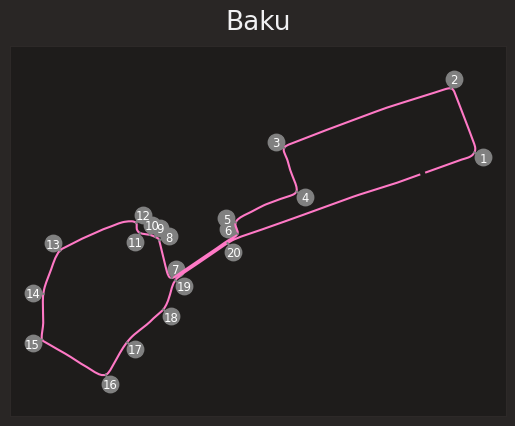

In [337]:
# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')
    
plt.title(session.event['Location'])
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()

### Speed

In [338]:
from matplotlib.collections import LineCollection

In [339]:
# driver = 'VER'
# lap = session.laps.pick_driver(driver).pick_fastest()

# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis
color = lap.telemetry['Speed']      # value to base color gradient on

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [340]:
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

from matplotlib import cm, colors, colorbar
colormap = cm.viridis_r

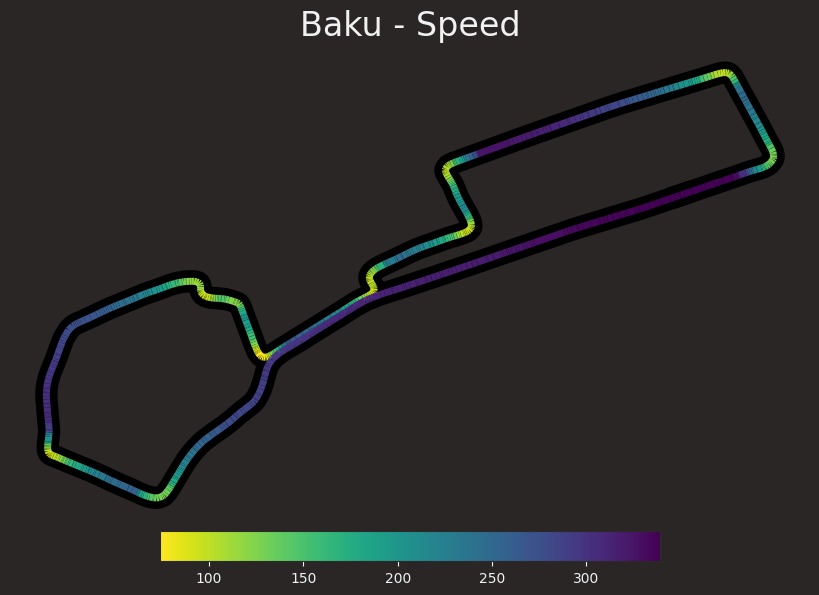

In [341]:
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 6))

fig.suptitle(f'{session.event['Location']} - Speed', size=24, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# After this, we plot the data itself.
# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'],
        color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=colormap, norm=norm,
                    linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)

# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = colors.Normalize(vmin=color.min(), vmax=color.max())
legend = colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                   orientation="horizontal")

# Show the plot
plt.show()

Si me da tiempo hacer porcentaje acelerador, marchas, lo que sea. Poco prioritario.

---

## Ritmos de carrera

### Drivers

In [148]:
# Enable Matplotlib patches for plotting timedelta values and load
# FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

In [167]:
race = session

point_finishers = race.drivers[:10]
print(point_finishers)
driver_laps = race.laps.pick_drivers(point_finishers).pick_quicklaps(threshold=1.07)
driver_laps = driver_laps.reset_index()

['81', '16', '63', '4', '1', '14', '23', '43', '44', '50']


In [168]:
finishing_order = [race.get_driver(i)["Abbreviation"] for i in point_finishers]
print(finishing_order)

['PIA', 'LEC', 'RUS', 'NOR', 'VER', 'ALO', 'ALB', 'COL', 'HAM', 'BEA']


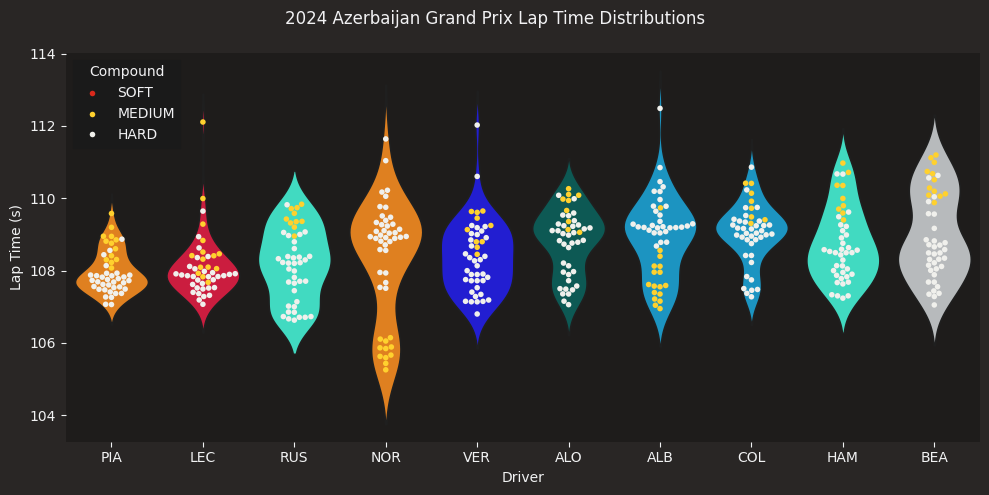

In [169]:
# create the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Seaborn doesn't have proper timedelta support,
# so we have to convert timedelta to float (in seconds)
driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()

sns.violinplot(data=driver_laps,
               x="Driver",
               y="LapTime(s)",
               hue="Driver",
               inner=None,
               density_norm="area",
               order=finishing_order,
               palette=fastf1.plotting.get_driver_color_mapping(session=race)
               )

sns.swarmplot(data=driver_laps,
              x="Driver",
              y="LapTime(s)",
              order=finishing_order,
              hue="Compound",
              palette=fastf1.plotting.get_compound_mapping(session=race),
              hue_order=["SOFT", "MEDIUM", "HARD"],
              linewidth=0,
              size=4,
              )

ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time (s)")
plt.suptitle("2024 Azerbaijan Grand Prix Lap Time Distributions")
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

### Teams

In [178]:
laps = race.laps.pick_quicklaps(threshold=1.07)

transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

# order the team from the fastest (lowest median lap time) tp slower
team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)
print(team_order)

# make a color palette associating team names to hex codes
team_palette = {team: fastf1.plotting.get_team_color(team, session=race)
                for team in team_order}

Index(['Ferrari', 'McLaren', 'Red Bull Racing', 'Mercedes', 'Haas F1 Team',
       'Aston Martin', 'Williams', 'RB', 'Alpine', 'Kick Sauber'],
      dtype='object', name='Team')


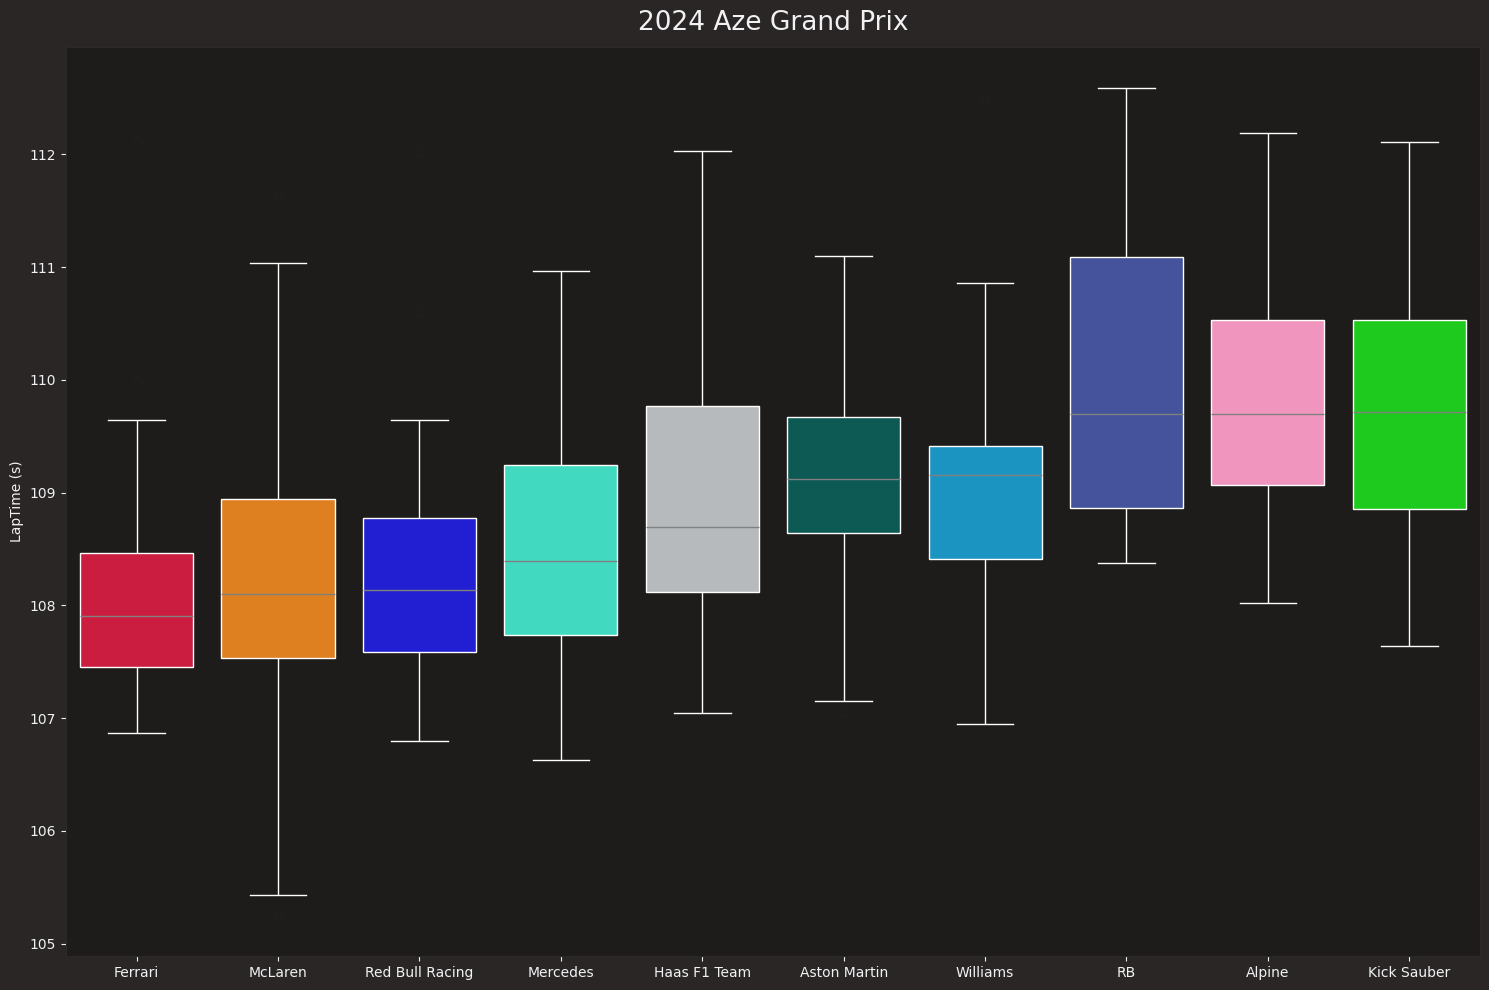

In [179]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(
    data=transformed_laps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
)

plt.title("2024 Aze Grand Prix")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()

Se puede cambiar a violin o swarm

---

## Tyre strat

In [181]:
drivers = session.drivers
print(drivers)

['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']


In [182]:
drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
print(drivers)

['PIA', 'LEC', 'RUS', 'NOR', 'VER', 'ALO', 'ALB', 'COL', 'HAM', 'BEA', 'HUL', 'GAS', 'RIC', 'ZHO', 'OCO', 'BOT', 'PER', 'SAI', 'STR', 'TSU']


In [185]:
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()

stints = stints.rename(columns={"LapNumber": "StintLength"})

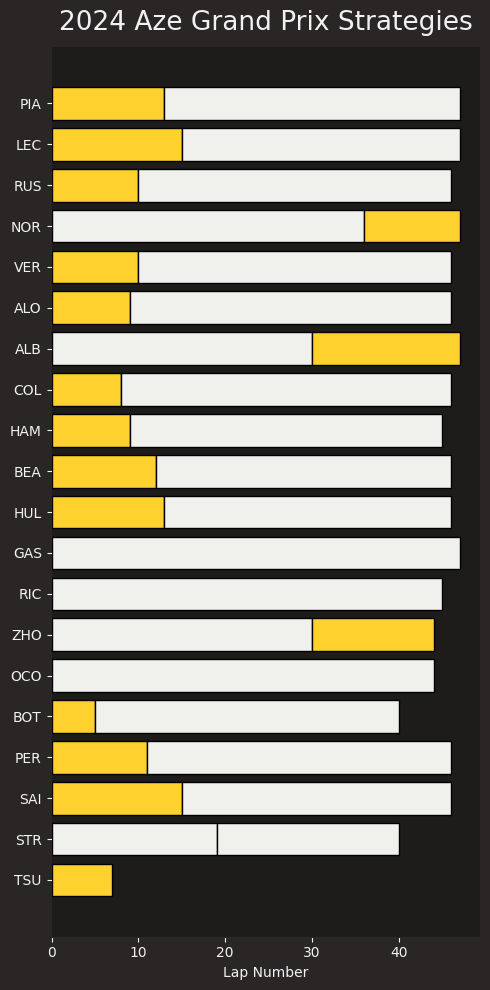

In [188]:
fig, ax = plt.subplots(figsize=(5, 10))

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        compound_color = fastf1.plotting.get_compound_color(row["Compound"],
                                                            session=session)
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color,
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]

plt.title("2024 Aze Grand Prix Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
# invert the y-axis so drivers that finish higher are closer to the top
ax.invert_yaxis()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

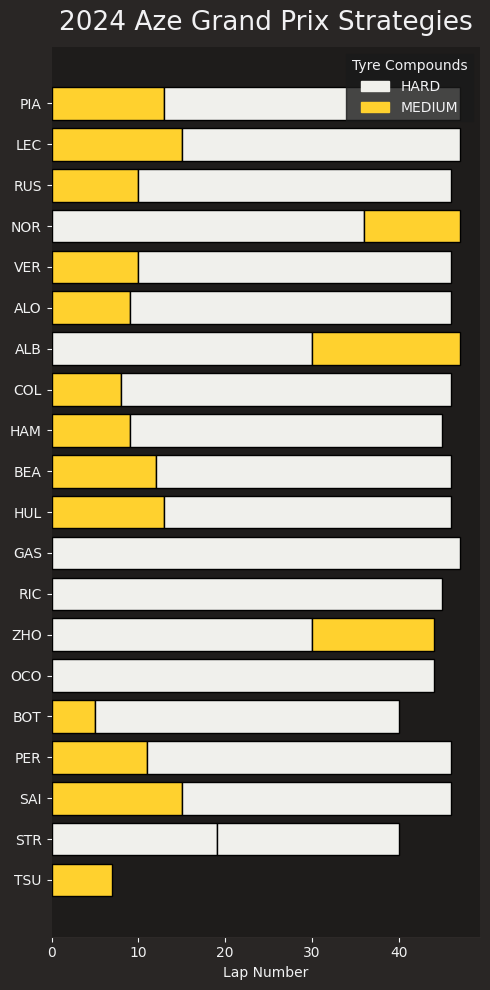

In [192]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(5, 10))

# Crear un diccionario de colores y compuestos
compounds = stints['Compound'].unique()
compound_colors = [fastf1.plotting.get_compound_color(compound, session=session) for compound in compounds]

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # Obtener el color del compuesto
        compound_color = fastf1.plotting.get_compound_color(row["Compound"], session=session)
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color,
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]

plt.title("2024 Aze Grand Prix Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
# Invertir el eje y para que los pilotos mejor clasificados estén en la parte superior
ax.invert_yaxis()

# Ocultar algunos bordes de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Crear la leyenda
legend_patches = [mpatches.Patch(color=color, label=compound) for compound, color in zip(compounds, compound_colors)]
plt.legend(handles=legend_patches, title="Tyre Compounds", loc="upper right")

plt.tight_layout()
plt.show()


---

## Qualy laps

In [195]:
# Enable Matplotlib patches for plotting timedelta values and load
# FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

In [196]:
fastest_lap = session_qualy.laps.pick_fastest()
car_data = fastest_lap.get_car_data().add_distance()

In [198]:
circuit_info = session_qualy.get_circuit_info()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


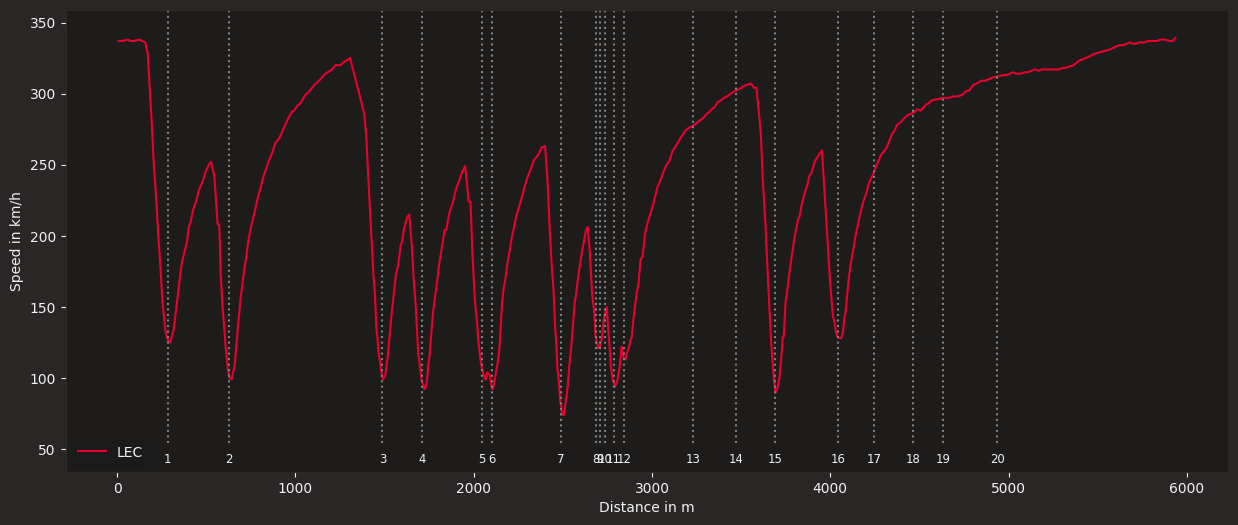

In [201]:
team_color = fastf1.plotting.get_team_color(fastest_lap['Team'],
                                            session=session)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(car_data['Distance'], car_data['Speed'],
        color=team_color, label=fastest_lap['Driver'])

# Draw vertical dotted lines at each corner that range from slightly below the
# minimum speed to slightly above the maximum speed.
v_min = car_data['Speed'].min()
v_max = car_data['Speed'].max()
ax.vlines(x=circuit_info.corners['Distance'], ymin=v_min-20, ymax=v_max+20,
          linestyles='dotted', colors='grey')

# Plot the corner number just below each vertical line.
# For corners that are very close together, the text may overlap. A more
# complicated approach would be necessary to reliably prevent this.
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], v_min-30, txt,
            va='center_baseline', ha='center', size='small')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')
ax.legend()

# Manually adjust the y-axis limits to include the corner numbers, because
# Matplotlib does not automatically account for text that was manually added.
ax.set_ylim([v_min - 40, v_max + 20])

plt.show()

### Dos pilotos

In [206]:
ver_lap = session_qualy.laps.pick_drivers(['VER']).pick_fastest()
ham_lap = session_qualy.laps.pick_drivers(['HAM']).pick_fastest()

In [207]:
ver_tel = ver_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()

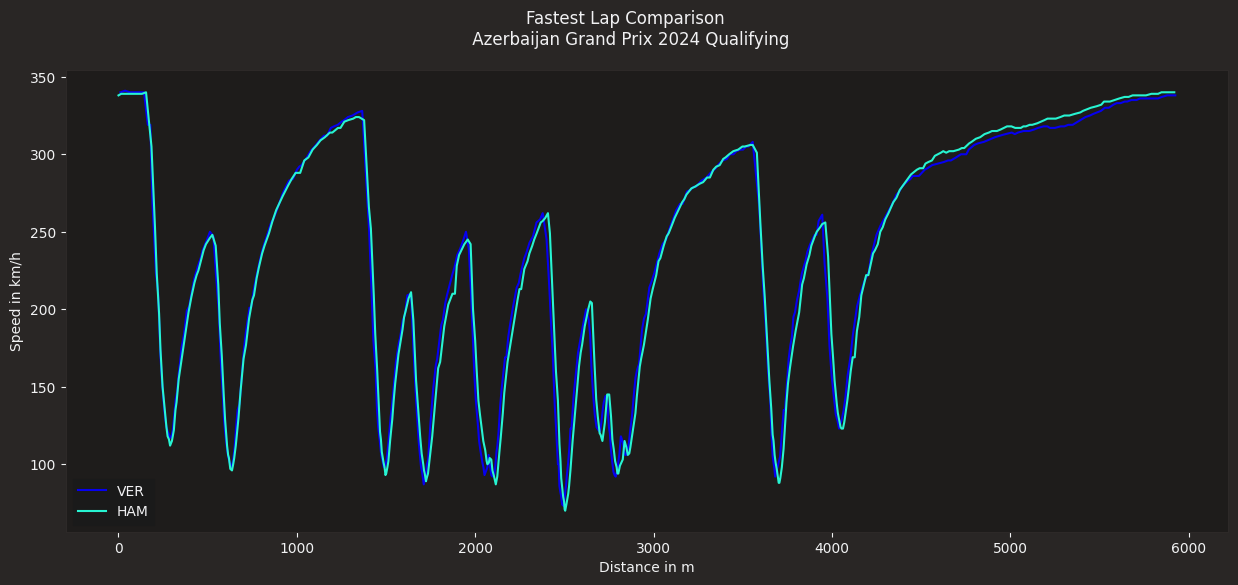

In [209]:
rbr_color = fastf1.plotting.get_team_color(ver_lap['Team'], session=session_qualy)
mer_color = fastf1.plotting.get_team_color(ham_lap['Team'], session=session_qualy)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color=rbr_color, label='VER')
ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=mer_color, label='HAM')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")

plt.show()

### Qualy results

In [212]:
drivers = session_qualy.laps['Driver'].unique()

In [214]:
list_fastest_laps = []

for drv in drivers:
    drvs_fastest_lap = session.laps.pick_drivers([drv]).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)

In [218]:
from fastf1.core import Laps

fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

In [220]:
pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

In [263]:
team_colors = []

for _, lap in fastest_laps.iterlaps():
    color = fastf1.plotting.get_team_color(lap['Team'], session=session_qualy)
    team_colors.append(color)

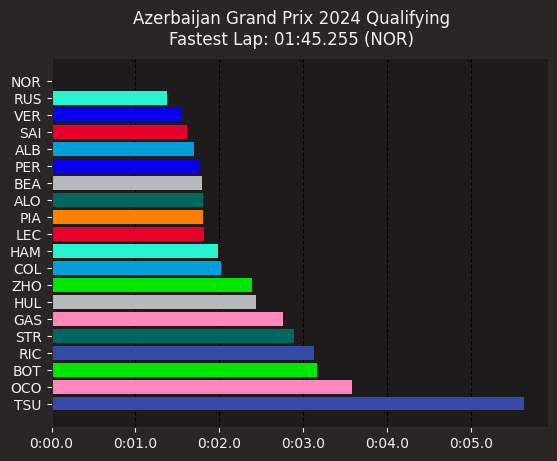

In [258]:
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors)
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = str(pole_lap['LapTime']).replace('0 days 00:', '').removesuffix('000')

plt.suptitle(f"{session_qualy.event['EventName']} {session_qualy.event.year} Qualifying\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

## Race results

In [344]:
drivers = session.laps['Driver'].unique()

In [345]:
df_results.reset_index(drop=True, inplace=True)

# El ganador tiene un delta de 0, lo voy a hardcodear
df_results.loc[0, 'Time'] = pd.Timedelta(0)

In [346]:
df_results.head()

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,DeltaPosition
0,81,O PIASTRI,PIA,piastri,McLaren,FF8000,mclaren,Oscar,Piastri,Oscar Piastri,...,1.0,1,2.0,NaT,NaT,NaT,0 days 00:00:00,Finished,25.0,1.0
1,16,C LECLERC,LEC,leclerc,Ferrari,E80020,ferrari,Charles,Leclerc,Charles Leclerc,...,2.0,2,1.0,NaT,NaT,NaT,0 days 00:00:10.910000,Finished,18.0,-1.0
2,63,G RUSSELL,RUS,russell,Mercedes,27F4D2,mercedes,George,Russell,George Russell,...,3.0,3,5.0,NaT,NaT,NaT,0 days 00:00:31.328000,Finished,15.0,2.0
3,4,L NORRIS,NOR,norris,McLaren,FF8000,mclaren,Lando,Norris,Lando Norris,...,4.0,4,15.0,NaT,NaT,NaT,0 days 00:00:36.143000,Finished,13.0,11.0
4,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671C6,red_bull,Max,Verstappen,Max Verstappen,...,5.0,5,6.0,NaT,NaT,NaT,0 days 00:01:17.098000,Finished,10.0,1.0


In [347]:
team_colors = df_results['TeamColor'].apply(lambda x: '#' + x).to_list()

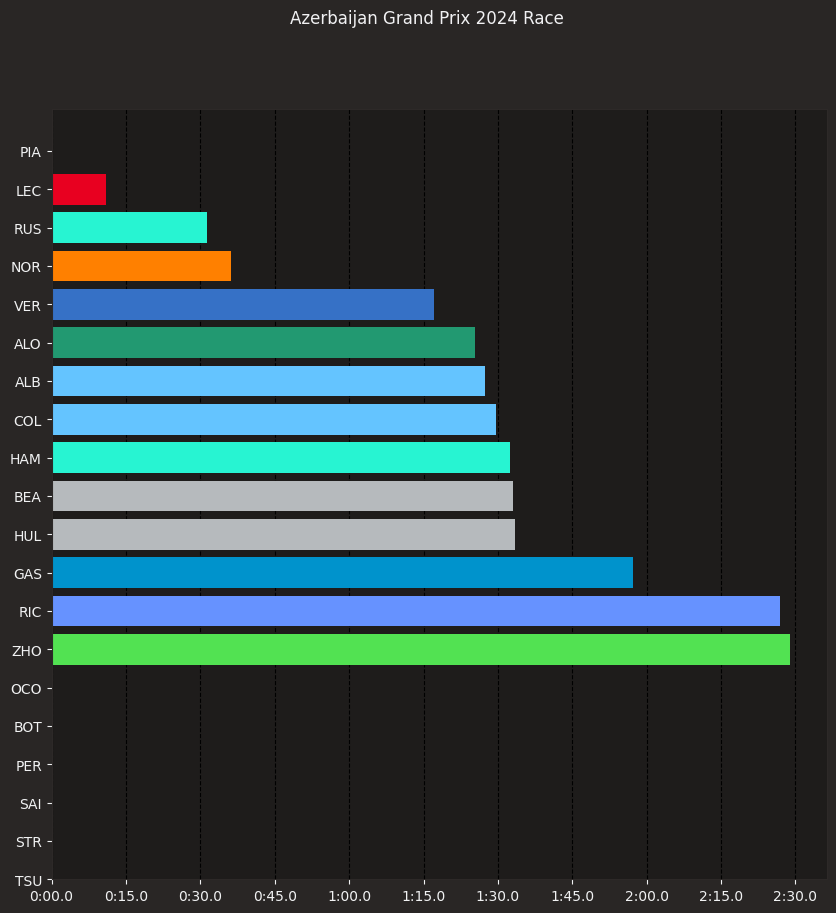

In [348]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.barh(df_results.index, df_results['Time'], color=team_colors)
ax.set_yticks(df_results.index)
ax.set_yticklabels(df_results['Abbreviation'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

plt.suptitle(f"{session.event['EventName']} {session.event.year} Race\n")

plt.show()

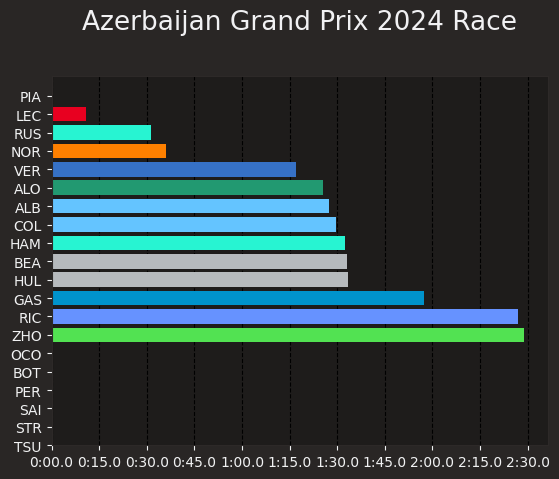

In [349]:
# Gráfico de barras horizontales
plt.barh(df_results.index, df_results['Time'], color=team_colors)

# Etiquetas del eje y
plt.yticks(df_results.index, df_results['Abbreviation'])

# Mostrar el tiempo más rápido arriba
plt.gca().invert_yaxis()

# Dibujar líneas verticales detrás de las barras
plt.grid(axis='x', which='major', linestyle='--', color='black', zorder=-1000)

# Título del gráfico
plt.title(f"{session.event['EventName']} {session.event.year} Race\n")

# Mostrar el gráfico
plt.show()

Con Seaborn

/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_54805/403167222.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




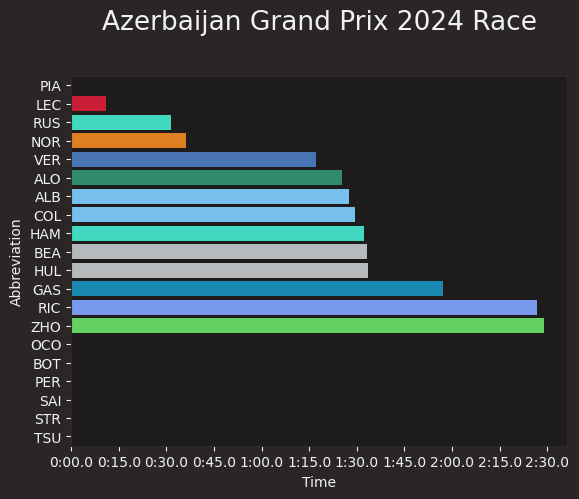

In [350]:
# Crear el gráfico de barras horizontales
sns.barplot(
    y=df_results['Abbreviation'],
    x=df_results['Time'], 
    orient="y",
    palette=team_colors
)

# Título del gráfico
plt.title(f"{session.event['EventName']} {session.event.year} Race\n")

# Mostrar el gráfico
plt.show()

Con Plotly

In [354]:
import plotly.express as px

# Configurar esquema de colores oscuro de FastF1
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False, color_scheme='fastf1')

# Crear el gráfico de barras horizontales
fig = px.bar(
    df_results,
    y='Abbreviation',  # Etiquetas en el eje y
    x=df_results['Time'].dt.total_seconds(),          # Valores de las barras
    color='Abbreviation',  # Usar una columna como base para los colores
    color_discrete_sequence=team_colors,  # Colores personalizados
    orientation='h'    # Orientación horizontal
)

# Ajustar el diseño para invertir el eje y
fig.update_layout(
    title=f"{session.event['EventName']} {session.event.year} Race",
    xaxis_title="Time (s)",
    yaxis_title="Abbreviation",
    xaxis=dict(tickvals=list(range(0, 150, 10))),
    plot_bgcolor='black',  # Fondo del gráfico
    paper_bgcolor='black',  # Fondo general
    font=dict(color='white')  # Texto general en blanco
)

# Mostrar el gráfico
fig.show()


---

### Drivers race pace

In [374]:
driver_laps = session.laps.pick_drivers(["ALO"]).pick_quicklaps().reset_index()

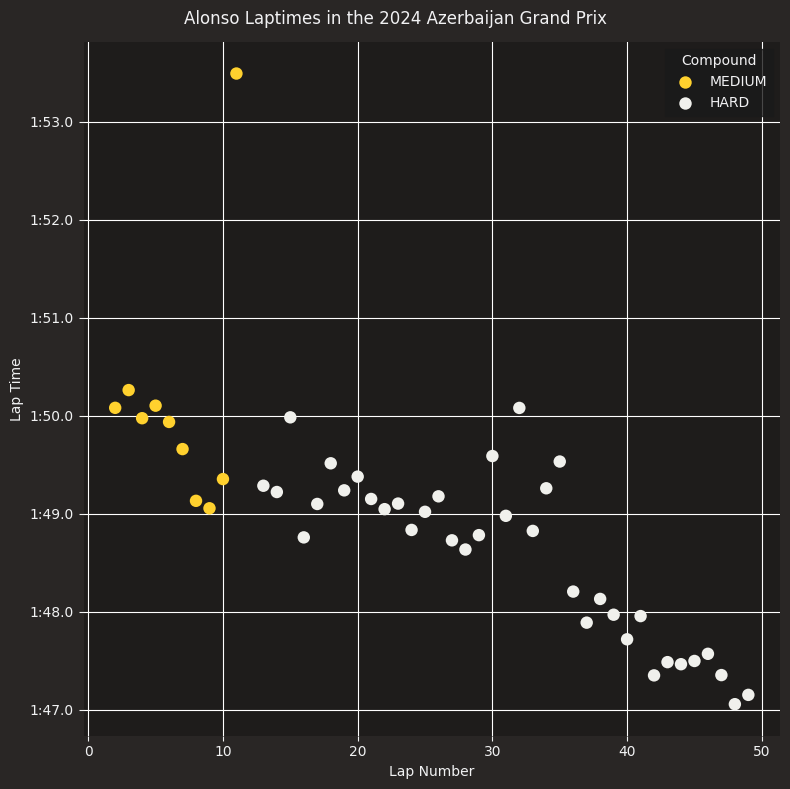

In [384]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=driver_laps,
                x="LapNumber",
                y="LapTime",
                ax=ax,
                hue="Compound",
                palette=fastf1.plotting.get_compound_mapping(session=session),
                s=80,
                linewidth=0,
                legend='auto')

ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")

# The y-axis increases from bottom to top by default
# Since we are plotting time, it makes sense to invert the axis
ax.invert_yaxis()
plt.suptitle("Alonso Laptimes in the 2024 Azerbaijan Grand Prix")

# Turn on major grid lines
plt.grid(color='w', which='major', axis='both')
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

### Driver comparison

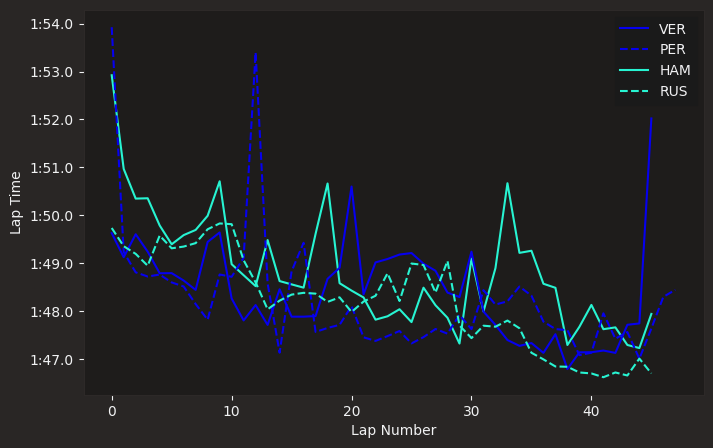

In [393]:
fig, ax = plt.subplots(figsize=(8, 5))

for driver in ('HAM', 'PER', 'VER', 'RUS'):
    laps = session.laps.pick_drivers([driver]).pick_quicklaps().reset_index()
    style = fastf1.plotting.get_driver_style(identifier=driver,
                                      style=['color', 'linestyle'],
                                      session=session)
    ax.plot(laps['LapTime'], **style, label=driver)

# add axis labels and a legend
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")
fastf1.plotting.add_sorted_driver_legend(ax, race)

---

## Telemetría

In [395]:
session.load()

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
_api           INFO 	Parsing car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
_api           INFO 	Parsing position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached dat

In [398]:
#load best lap from driver
LapNor = session.laps.pick_drivers(["NOR"]).pick_fastest()
LapVer = session.laps.pick_drivers(["VER"]).pick_fastest()
LapHam = session.laps.pick_drivers(["HAM"]).pick_fastest()

#get telemetry of each lap
NOR = LapNor.get_telemetry()
VER = LapVer.get_telemetry()
HAM = LapHam.get_telemetry()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [400]:
NOR["Brake"] = NOR["Brake"].replace({True: 100, False: 0})
NOR["Pedal"] = NOR["Throttle"] - NOR["Brake"]
HAM["Brake"] = HAM["Brake"].replace({True: 100, False: 0})
HAM["Pedal"] = HAM["Throttle"] - HAM["Brake"]
VER["Brake"] = VER["Brake"].replace({True: 100, False: 0})
VER["Pedal"] = VER["Throttle"] - VER["Brake"]

/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_54805/2671805812.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_54805/2671805812.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_54805/2671805812.py:5: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to 

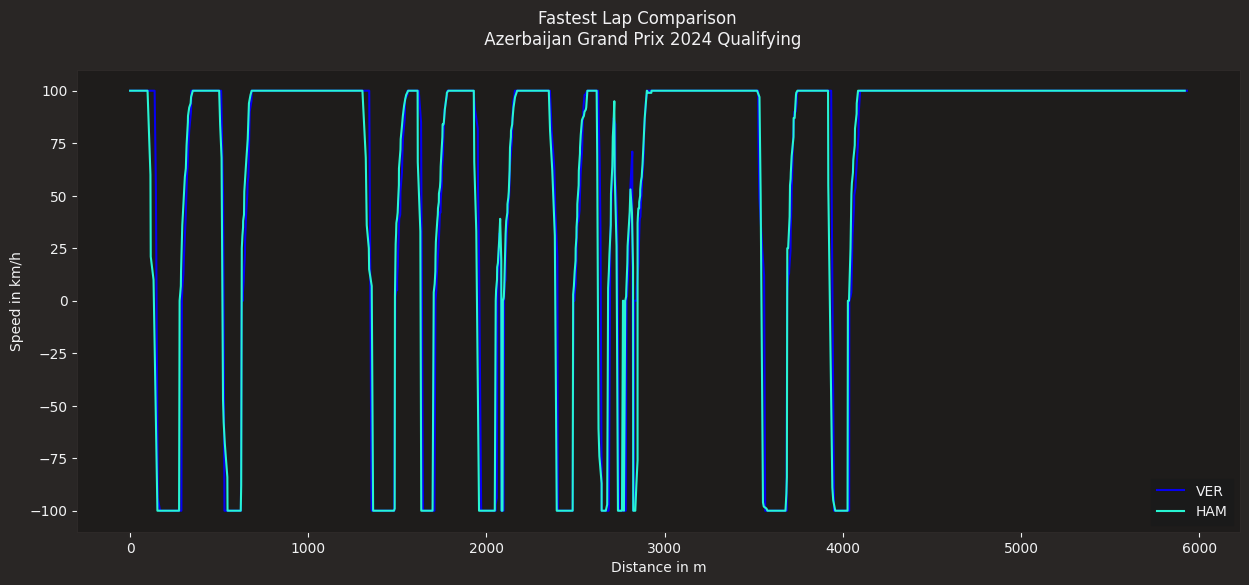

In [402]:
rbr_color = fastf1.plotting.get_team_color(ver_lap['Team'], session=session_qualy)
mer_color = fastf1.plotting.get_team_color(ham_lap['Team'], session=session_qualy)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(VER['Distance'], VER['Pedal'], color=rbr_color, label='VER')
ax.plot(HAM['Distance'], HAM['Pedal'], color=mer_color, label='HAM')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")

plt.show()